In [2]:
# Import modules

import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"   # must happen before importing jax

import argparse
import jax
import numpy as np
import numpyro
from numpyro.infer import Predictive, MCMC, NUTS
import jax.numpy as jnp
from helper import import_dataset, plot_utterance_distribution
from modelSpecification import likelihood_function_global_speaker, likelihood_function_incremental_speaker, global_speaker, incremental_speaker, incremental_semantics_jax
import matplotlib.pyplot as plt
import seaborn as sns
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
print(jax.__version__)
from jax.random import PRNGKey, split
from jax import random
import arviz as az

0.4.28
[CpuDevice(id=0)]
0.4.28


## Prior predictive checks

## SBC analysis

In this section we perform **Simulation-Based Calibration (SBC)** for both
the **global speaker** and the **incremental speaker** models.

Concretely:

- For each SBC replication:
  1. Sample parameters \(\theta\) from the **prior**.
  2. Simulate a full dataset \(y^{\text{sim}}\) from the model \(P(y \mid \theta)\).
  3. Run MCMC to obtain posterior draws \(\{\theta^{(m)}\}_{m=1}^M \sim P(\theta \mid y^{\text{sim}})\).
  4. Compute the **rank** of the true parameter \(\theta\) among the posterior draws:
     \[
     \text{rank}(\theta) = \#\{\theta^{(m)} < \theta\}.
     \]
- Repeat this for many replications and for each parameter of interest.
- Compare the empirical distribution of ranks to the **ideal uniform distribution**.

---

### What is SBC?

**Simulation-Based Calibration** is a general diagnostic for Bayesian
inference algorithms (MCMC, SVI, etc.). The key idea:

- If we:
  - draw \(\theta\) from the prior \(P(\theta)\),
  - simulate data \(y \sim P(y \mid \theta)\),
  - and then compute the posterior \(P(\theta \mid y)\),
- then, under a **correctly specified model** and a **well-calibrated inference algorithm**,  
  the true parameter \(\theta\) should behave like a **random draw from its own posterior**.

This implies that the **rank** of \(\theta\) among the posterior draws is
**uniformly distributed** over \(\{0, 1, \dots, M\}\), where \(M\) is the number of
posterior draws per SBC run.

Formally, for each parameter dimension:
\[
\text{rank}(\theta) = \#\{\theta^{(m)} < \theta\}
\quad\Rightarrow\quad
\text{rank} \sim \text{Uniform}\{0, \dots, M\}.
\]

If the ranks deviate systematically from uniformity, this signals:

- model mis-specification,
- biased or poorly mixing inference,
- implementation bugs (e.g., wrong likelihood, wrong prior, indexing errors).

---

### Output: rank plots and how to interpret them

The SBC analysis produces **rank histograms** (also called SBC rank plots)
for each parameter, separately for:

- the **global speaker** model, and
- the **incremental speaker** model.

Each histogram shows:

- **x-axis**: rank values \(0, 1, \dots, M\) (where \(M\) = number of posterior draws),
- **y-axis**: empirical frequency (or density) of that rank across SBC replications,
- a **horizontal reference line** at height \(1/(M+1)\) for a perfectly uniform distribution.

How to read them:

- **Flat / uniform histogram**  
  → inference for that parameter is well-calibrated under the prior predictive
  data-generating process; no obvious bias detected.

- **U-shaped histogram (excess at 0 and \(M\))**  
  → posterior is **too concentrated** (overconfident); true values often fall in the tails.

- **Hump in the middle**  
  → posterior is **too diffuse** (underconfident); true values often fall near the center.

- **Skewed / monotonic shape**  
  → **systematic bias**: e.g. ranks clustering near 0 indicates that the posterior
  tends to be **larger** than the true value; clustering near \(M\) indicates the
  posterior tends to be **smaller** than the true value.

- **Different patterns for global vs incremental speaker**  
  → highlight differences in how each model (and its inference) behaves under the same
  prior predictive process; this is especially useful to diagnose which components
  of the model (e.g., incremental semantics, utterance cost, LM prior) introduce
  calibration issues.

In short, **good SBC** ≈ **flat rank histograms**. Any systematic deviation is a clue
about where the model or inference might need refinement.

In [3]:
# Names of your parameters in the model:
PARAM_NAMES = ["alpha", "beta", "color_semvalue", "size_semval", "wf"]
states_train = import_dataset()["states_train"]

num_sbc = 50  # how many SBC datasets you want
prior_predictive = Predictive(
    likelihood_function_incremental_speaker,
    num_samples=num_sbc,
    return_sites=PARAM_NAMES + ["obs"],
)

num_sbc = 50  # how many SBC datasets you want
rng_key = PRNGKey(2)
prior_inc = prior_predictive(rng_key, states_train)
# shapes: prior_inc["obs"] -> (num_sbc, n_data)
#         prior_inc["alpha"] -> (num_sbc,)

In [4]:
def run_sbc(
    model_fn,
    states,
    num_sbc: int = 50,
    num_mcmc_samples: int = 500,
    num_mcmc_warmup: int = 500,
    rng_seed: int = 0,
):
    """
    Run simulation-based calibration (SBC).

    Returns
    -------
    ranks : dict[str, list[int]]
        Rank statistics per parameter.
    true_params : dict[str, np.ndarray]
        True parameter values used to generate each dataset.
    """

    # ------------------------------------------------------------------
    # 1) Identify latent parameter names automatically
    # ------------------------------------------------------------------
    # We run a single prior predictive draw to detect parameter sites
    probe = Predictive(model_fn, num_samples=1)(
        PRNGKey(rng_seed), states
    )

    param_names = [
        k for k in probe.keys()
        if k != "obs"
    ]

    print("SBC parameters:", param_names)

    # ------------------------------------------------------------------
    # 2) Prior predictive simulation (parameters + datasets)
    # ------------------------------------------------------------------
    prior_predictive = Predictive(
        model_fn,
        num_samples=num_sbc,
        return_sites=param_names + ["obs"],
    )

    rng_key = PRNGKey(rng_seed + 1)
    prior_samples = prior_predictive(rng_key, states)

    # ------------------------------------------------------------------
    # 3) Containers
    # ------------------------------------------------------------------
    ranks = {name: [] for name in param_names}
    true_params = {name: np.asarray(prior_samples[name]) for name in param_names}

    # One RNG per SBC run
    mcmc_keys = split(PRNGKey(rng_seed + 2), num_sbc)

    # ------------------------------------------------------------------
    # 4) SBC loop (intentionally NOT jitted)
    # ------------------------------------------------------------------
    for i in range(num_sbc):
        print(f"SBC replication {i+1}/{num_sbc}")

        y_i = np.asarray(prior_samples["obs"][i])
        theta_i = {name: float(true_params[name][i]) for name in param_names}

        kernel = NUTS(model_fn)
        mcmc = MCMC(
            kernel,
            num_warmup=num_mcmc_warmup,
            num_samples=num_mcmc_samples,
            num_chains=1,   # IMPORTANT for SBC stability
            progress_bar=True,
        )

        mcmc.run(mcmc_keys[i], states, y_i)
        post = mcmc.get_samples()

        for name in param_names:
            draws = np.asarray(post[name])
            rank = np.sum(draws < theta_i[name])
            ranks[name].append(rank)

    return ranks, true_params

import matplotlib.pyplot as plt


def plot_sbc_ranks(ranks, num_draws, bins=20):
    n = len(ranks)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 3), sharey=True)

    for ax, (name, r) in zip(axes, ranks.items()):
        ax.hist(r, bins=bins, range=(0, num_draws), density=True)
        ax.axhline(1 / num_draws, color="black", linestyle="--", alpha=0.5)
        ax.set_title(name)
        ax.set_xlabel("rank")

    axes[0].set_ylabel("density")
    plt.tight_layout()
    plt.show()

In [4]:
num_mcmc_samples = 20
ranks_gb, true_gb = run_sbc(
    model_fn=likelihood_function_global_speaker,
    states=states_train,
    num_sbc=10,
    num_mcmc_samples=50,
    num_mcmc_warmup=50,
)

SBC parameters: ['alpha', 'beta', 'color_semvalue', 'size_semval', 'wf']
SBC replication 1/10


sample: 100%|██████████| 100/100 [01:19<00:00,  1.27it/s, 23 steps of size 2.84e-02. acc. prob=0.97]


SBC replication 2/10


sample: 100%|███████████| 100/100 [00:57<00:00,  1.74it/s, 7 steps of size 1.99e-01. acc. prob=0.74]


SBC replication 3/10


sample: 100%|██████████| 100/100 [02:05<00:00,  1.26s/it, 23 steps of size 1.36e-01. acc. prob=0.83]


SBC replication 4/10


sample: 100%|███████████| 100/100 [00:39<00:00,  2.50it/s, 3 steps of size 2.85e-01. acc. prob=0.94]


SBC replication 5/10


sample: 100%|████████| 100/100 [30:38<00:00, 18.38s/it, 1023 steps of size 1.12e-04. acc. prob=0.85]


SBC replication 6/10


sample: 100%|███████████| 100/100 [00:34<00:00,  2.92it/s, 3 steps of size 8.52e-02. acc. prob=0.86]


SBC replication 7/10


sample: 100%|████████| 100/100 [30:33<00:00, 18.33s/it, 1023 steps of size 6.18e-05. acc. prob=0.87]


SBC replication 8/10


sample: 100%|█████████| 100/100 [18:29<00:00, 11.10s/it, 767 steps of size 6.05e-04. acc. prob=0.81]


SBC replication 9/10


sample: 100%|███████████| 100/100 [00:51<00:00,  1.94it/s, 9 steps of size 1.54e-01. acc. prob=0.67]


SBC replication 10/10


sample: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s, 15 steps of size 1.42e-01. acc. prob=0.86]


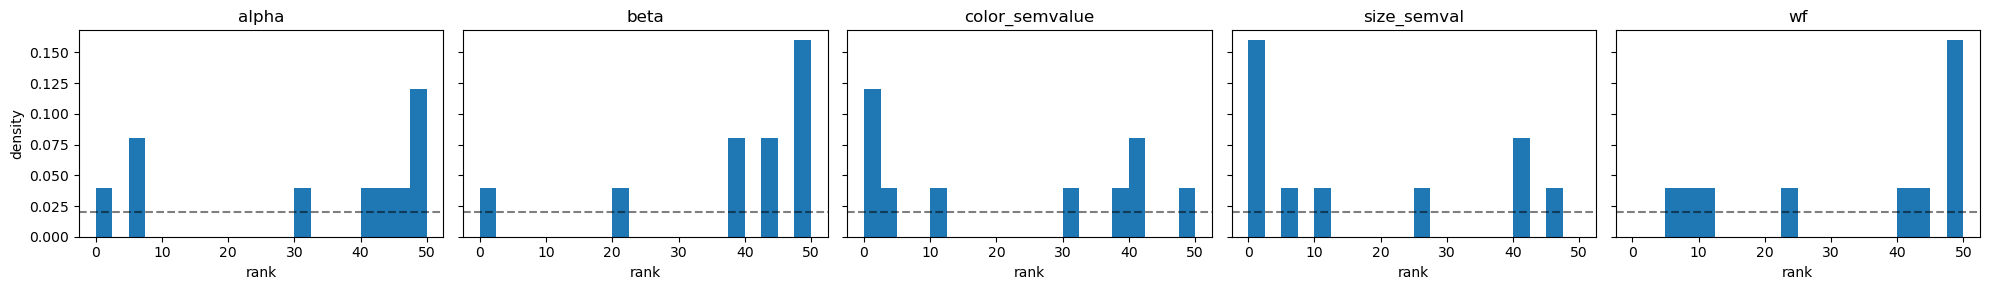

In [12]:
import pandas as pd
plot_sbc_ranks(ranks_gb, num_draws=50)

In [ ]:
ranks_inc, true_inc = run_sbc(
    model_fn=likelihood_function_incremental_speaker,
    states=states_train,
    num_sbc=10,
    num_mcmc_samples=50,
    num_mcmc_warmup=50,
)

SBC parameters: ['alpha', 'beta', 'color_semvalue', 'size_semval', 'wf']
SBC replication 1/10


sample: 100%|██████████| 100/100 [11:03<00:00,  6.64s/it, 31 steps of size 1.39e-01. acc. prob=0.89]


SBC replication 2/10


sample: 100%|███████████| 100/100 [11:20<00:00,  6.80s/it, 7 steps of size 1.52e-01. acc. prob=0.77]


SBC replication 3/10


sample: 100%|███████████| 100/100 [10:19<00:00,  6.20s/it, 3 steps of size 1.49e-01. acc. prob=0.88]


SBC replication 4/10


sample: 100%|███████████| 100/100 [08:03<00:00,  4.83s/it, 7 steps of size 2.15e-01. acc. prob=0.94]


SBC replication 5/10


warmup:  11%|█▏         | 11/100 [01:03<18:00, 12.14s/it, 63 steps of size 1.25e-03. acc. prob=0.54]

In [ ]:
plot_sbc_ranks(ranks_inc, num_draws=300)